# Intro to Text Classification

In this notebook we experiment with methods to transform sentences into vectors, and use vectors for text classification.

While a lot of contemporary NLP is neural, discussing simpler techniques first will help us introduce some terminology and build some intuition on what (doesn't) work(s) and why.

You are encouraged to play around with the code and modify / re-built parts of it as you fit: there is NO substitute for "tinkering with code" to understand how all the concepts fit together (corollary: all this code is written for pedagogical purposes, so some functions are re-used from previous lectures to provide a self-sufficient script).

In [1]:
# some global import
# we import specific libraries in due time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

## Data loading

In [3]:
import string

# some utils function
def get_finance_sentiment_dataset(split: str='sentences_allagree'):
    # load financial dataset from HF
    from datasets import load_dataset
    # https://huggingface.co/datasets/financial_phrasebank
    # by default, load just sentences for which all annotators agree
    dataset = load_dataset("financial_phrasebank", split)
    
    return dataset['train']


def get_finance_sentences():
    dataset = get_finance_sentiment_dataset()
    cleaned_dataset = [[pre_process_sentence(_['sentence']), _['label']] for _ in dataset]
    # debug 
    print("{} cleaned sentences from finance dataset\n".format(len(cleaned_dataset)))
    
    return cleaned_dataset


def pre_process_sentence(sentence: str):
    # this choices are VERY important. Here, we take a simplified 
    # view, remove the punctuations and just lower case everything
    lower_sentence = sentence.lower()
    # remove punctuation
    # nice suggestion from https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    # if we change the exclude set, we can control what to exclude
    exclude = set(string.punctuation)
    return ''.join(ch for ch in lower_sentence if ch not in exclude)

In [4]:
finance_dataset = get_finance_sentences()
# print out the first items in the dataset, to check the format
finance_dataset[:2]

/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/11/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2264 cleaned sentences from finance dataset



[['according to gran  the company has no plans to move all production to russia  although that is where the company is growing ',
  1],
 ['for the last quarter of 2010  componenta s net sales doubled to eur131m from eur76m for the same period a year earlier  while it moved to a zero pretax profit from a pretax loss of eur7m ',
  2]]

In [5]:
# get sentences without label for vectorizer part
finance_dataset_sentences = [_[0] for _ in finance_dataset]

## Introducing count and tf-idf vectorizer

_Computers do NOT understand words, so the first thing to do is to map the sentences found in the dataset to vectors of numbers._

The oldest trick for manipulating text is the so-called "vector space model" (still very much in Information Retrieval), which is simply the idea that you can map documents to vectors and use "geometric notions" to compute interesting metrics, such as semantic similarity. The oldest mapping between words and vectors is a simple count transformation:

D1: 'The bill is passed.'
D2: 'Jesse proposed the bill.'

D1: The=1, bill=1, is=1, passed=1, Jesse=0, proposed=0
D2: The=1, bill=1, is=0, passed=0, Jesse=1, proposed=1

A more sophisticated version is TF-IDF, which is the foundation of most search engines (SOLR, Elastic etc.): vectors are not counts, but they weights, as we discussed in class. 

Let's see the difference with some Python examples.

In [6]:
# difference between count and tf-idf vectors
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# example docs
docs = finance_dataset_sentences[:2]
# instantiate the vectorizer object
countvectorizer = CountVectorizer(analyzer='word')
tfidfvectorizer = TfidfVectorizer(analyzer='word')
# convert the documents into a matrix
count_wm = countvectorizer.fit_transform(docs)
tfidf_wm = tfidfvectorizer.fit_transform(docs)
# display the difference
count_tokens = countvectorizer.get_feature_names_out()
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data=count_wm.toarray(),
                            index=['Doc{}'.format(_) for _ in range(len(docs))], 
                            columns=count_tokens)
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(),
                            index=['Doc{}'.format(_) for _ in range(len(docs))], 
                            columns=tfidf_tokens)
print("Count Vectorizer\n")
print(df_countvect)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)

Count Vectorizer

      2010  according  all  although  company  componenta  doubled  earlier  \
Doc0     0          1    1         1        2           0        0        0   
Doc1     1          0    0         0        0           1        1        1   

      eur131m  eur76m  ...  russia  sales  same  that  the  to  where  while  \
Doc0        0       0  ...       1      0     0     1    2   3      1      0   
Doc1        1       1  ...       0      1     1     0    2   2      0      1   

      year  zero  
Doc0     0     0  
Doc1     1     1  

[2 rows x 41 columns]

TD-IDF Vectorizer

          2010  according       all  although   company  componenta   doubled  \
Doc0  0.000000   0.190412  0.190412  0.190412  0.380823    0.000000  0.000000   
Doc1  0.158015   0.000000  0.000000  0.000000  0.000000    0.158015  0.158015   

       earlier   eur131m    eur76m  ...    russia     sales      same  \
Doc0  0.000000  0.000000  0.000000  ...  0.190412  0.000000  0.000000   
Doc1  0.15801

* Important observation # 1: the size of the vector for each doc is proportional to vocabulary size.
* Important observation # 2: the vectors are mostly empty (it is a "sparse" representation). As we shall see in future lectures, neural network produces "dense" representations.

In [7]:
# see how vector dimension changes with more docs
docs = finance_dataset_sentences[:100]
countvectorizer = CountVectorizer(analyzer='word')
count_wm = countvectorizer.fit_transform(docs)
count_tokens = countvectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data=count_wm.toarray(), 
                            index=['Doc{}'.format(_) for _ in range(len(docs))], 
                            columns=count_tokens)
print("Count Vectorizer\n")
print(df_countvect)

Count Vectorizer

       000  04  08  10  100  100mn  1015  10270  1033  10507  ...  will  with  \
Doc0     0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc1     0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc2     0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc3     0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc4     0   0   0   0    0      0     0      0     0      0  ...     0     0   
...    ...  ..  ..  ..  ...    ...   ...    ...   ...    ...  ...   ...   ...   
Doc95    0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc96    0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc97    0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc98    0   0   0   0    0      0     0      0     0      0  ...     0     0   
Doc99    0   0   0   0    0      0     0      0     0      0  ...     0     0   

       wo

If documents are points in a |V| dimensional space, their similarity is given by the angle between them: we show how to compute similarity with cosine first, and then wrap it up in a function:

In [8]:
# calculate similarity using cosine similarity
from sklearn.metrics.pairwise import linear_kernel
docs = finance_dataset_sentences[:5]
tfidfvectorizer = TfidfVectorizer(analyzer='word')
tfidf_wm = tfidfvectorizer.fit_transform(docs)
cosine_similarities = linear_kernel(tfidf_wm, tfidf_wm).flatten()
# print out for debug - the diagonal is 1 as all documents are perfectly
# similar to themselves
cosine_similarities

array([1.        , 0.11464047, 0.11429394, 0.08137724, 0.        ,
       0.11464047, 1.        , 0.19580002, 0.20496747, 0.1271767 ,
       0.11429394, 0.19580002, 1.        , 0.41496965, 0.36717405,
       0.08137724, 0.20496747, 0.41496965, 1.        , 0.57810913,
       0.        , 0.1271767 , 0.36717405, 0.57810913, 1.        ])

In [9]:
# wrap up similarity calculation in a function
def most_similar_docs_tf_idf(target_doc_index, docs, tfidf, top_k=3, debug=False):
    sims = linear_kernel(tfidf[target_doc_index:target_doc_index + 1], tfidf).flatten()
    indices = sims.argsort()[:-top_k-2:-1]
    
    if debug:
        print(indices)
    
    return [docs[i] for i in indices]

In [10]:
for idx, d in enumerate(docs):
    print("\n======== Most similar docs to: {}\n".format(d))
    print(most_similar_docs_tf_idf(idx, docs, tfidf_wm)[1:])


======== Most similar docs to: according to gran  the company has no plans to move all production to russia  although that is where the company is growing 

['for the last quarter of 2010  componenta s net sales doubled to eur131m from eur76m for the same period a year earlier  while it moved to a zero pretax profit from a pretax loss of eur7m ', 'in the third quarter of 2010  net sales increased by 52  to eur 2055 mn  and operating profit by 349  to eur 235 mn ', 'operating profit rose to eur 131 mn from eur 87 mn in the corresponding period in 2007 representing 77  of net sales ']

======== Most similar docs to: for the last quarter of 2010  componenta s net sales doubled to eur131m from eur76m for the same period a year earlier  while it moved to a zero pretax profit from a pretax loss of eur7m 

['operating profit rose to eur 131 mn from eur 87 mn in the corresponding period in 2007 representing 77  of net sales ', 'in the third quarter of 2010  net sales increased by 52  to eur 2

_Let's run on all the dataset now!!!_

In [11]:
all_text_data = finance_dataset_sentences

* Important observation: the scikit vectorizer comes with MANY options (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). As we discussed in class, there are non-equivalent ways of cleaning text, tokenize it, etc. The removal of stop words, or how frequent a word should be to be included in the model, or what ngram size to use, are governed by parameters that can be tweaked.

In [12]:
finance_tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
finance_tfidf_wm = tfidfvectorizer.fit_transform(all_text_data)

We pick a random sentence from our data, and compute the most similar sentences according to TF-IDF...

In [13]:
from random import randint
rnd_idx = randint(0, len(all_text_data))
print("\n======== Most similar docs to:\n {}-{}\n\n".format(rnd_idx, all_text_data[rnd_idx]))
top_docs = most_similar_docs_tf_idf(rnd_idx, all_text_data, finance_tfidf_wm, debug=True)
for t in top_docs[1:]:
    print(t, '\n')


======== Most similar docs to:
 1263-includes company and brand share data by category  as well as distribution channel data 


[1263 1815  680  267]
the report contains category level company and brand share as well as distribution share information for 2007 and 2008  

product coverage  baked goods  biscuits  breakfast cereals data coverage  market sizes historic and forecasts  company shares  brand shares and distribution data  

a data processing unit collects the data  calculates rvr values and provides the data to users via various interfaces  



## Applied Vectorization: Text Classification

Once we have vectors, we can proceed to build a classifier pretty much exactly like you did for other supervised learning projects in the class.

In [14]:
from sklearn.model_selection import train_test_split

finance_dataset_text = [_[0] for _ in finance_dataset]
finance_dataset_label = [_[1] for _ in finance_dataset]
all_labels = set(finance_dataset_label)
print("All labels are: {}".format(all_labels))
X_train, X_test, y_train, y_test = train_test_split(finance_dataset_text, 
                                                    finance_dataset_label, 
                                                    test_size=0.1, 
                                                    random_state=42)

All labels are: {0, 1, 2}


In [15]:
print(len(X_train), len(X_test), X_train[:3], y_train[:3])

2037 227 ['the train is expected to cross the russian territory in 9 days  reaching the vostochny port ', 'the policy was also aimed at making the companies more profitable and competitive ', 'no financial details were disclosed '] [1, 2, 1]


In [16]:
final_tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
final_tfidf_train = final_tfidfvectorizer.fit_transform(X_train)
final_tfidf_train.shape

(2037, 6065)

In [17]:
X_test_transformed = final_tfidfvectorizer.transform(X_test)

#### Bonus: Chi-Square selection

If the model is too big (remember: the model grows with vocabulary size!), we can check which words are most predictive of the target label, and trim the model accordingly (i.e. we are doing feature selection on our text data - see for example https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [18]:
feature_names = final_tfidfvectorizer.get_feature_names_out()
print(len(feature_names), feature_names[-3:])

6065 ['àmñl' 'ál' 'äñnekoski']


In [19]:
from sklearn.feature_selection import SelectKBest, chi2

ch2 = SelectKBest(chi2, k=25)
X_chi_train = ch2.fit_transform(final_tfidf_train, y_train)
X_chi_test = ch2.transform(X_test_transformed)
new_feature_names =  np.array(feature_names)[ch2.get_support()]
print(len(new_feature_names), new_feature_names[:10])

25 ['2008' 'compared' 'corresponding' 'decreased' 'dropped' 'eur' 'fell'
 'grew' 'half' 'increase']


_We now instantiate a classifier, train it and then predicting unseen test cases as usual._

In [20]:
from sklearn.naive_bayes import MultinomialNB
# from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

model = MultinomialNB()
# train and test the classifier
model.fit(final_tfidf_train, y_train)
predicted = model.predict(X_test_transformed)
predicted_prob = model.predict_proba(X_test_transformed)

In [21]:
# debug
print(predicted[:3], predicted_prob[:3])

[1 1 2] [[0.04644567 0.81626586 0.13728847]
 [0.11744389 0.71779367 0.16476244]
 [0.21494976 0.17169911 0.61335113]]


* Important observation: thanks to scikit great API, we can re-run the code below swapping in and out different classifiers, and compare their performance easily - for example, we could try a LinearSVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)!

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_confusion_matrix_and_report(y_predicted, y_golden, with_plot=True):
    # calculate confusion matrix: 
    cm = confusion_matrix(y_golden, y_predicted)
    # build a readable report;
    # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report
    print('\nClassification Report')
    print(classification_report(y_golden, y_predicted))
    # plot the matrix
    if with_plot:
        plot_confusion_matrix(cm)
                                          
    return
                                          
def plot_confusion_matrix(c_matrix):
    plt.imshow(c_matrix, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.show()
    
    return

As usual, we first try to understand the model behavior on unseen data through some rough quantitative measures and visualization. 

Total of # 227 test cases

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.84      0.95      0.89       145
           2       0.61      0.71      0.65        52

    accuracy                           0.78       227
   macro avg       0.81      0.57      0.54       227
weighted avg       0.81      0.78      0.73       227



/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/11/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/11/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/11/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)

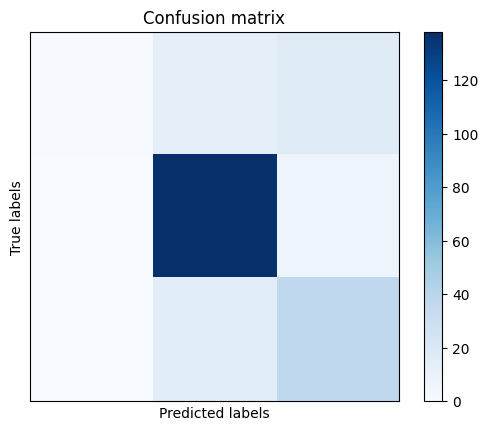

In [23]:
print("Total of # {} test cases".format(len(y_test)))
calculate_confusion_matrix_and_report(predicted, y_test)